# Survival Analysis with Neural Networks

The provided dataset [`MG.sav`](MG.sav) contains the survival data of `1,802` patients with chronic heart failure.

## Introduction

For an analysis done as part of his PhD thesis, John Mbotwa reduced the this dataset to `PatientID` with `6` covariates: `Diabetes`, `StatusDeath`, `TimeDeath`, `ClinicDeath`, `Haemoglobin` and `Sex` `(de Kamps, 2023)`. The full dataset was presented in a `.sav` file called `"MG HF cohorts 1 to 3 May 2016 censored.sav"`, here renamed to `MG.sav` because of the white space in the title. See `Appendix B` in the report for the data dictionary.

## Data preparation

The first common sense check is see whether all covariates in John's `FinalData` spreadsheet are present and whether the units makes sense. This is a `10` year study and the time units report in the `FinalData` spreadsheet seem days since start of study. `(de Kamps, 2023)`

In [108]:
import random

# Set random seed for future reproducibility
seed = 42
random.seed(seed)

# Define path to the dataset
mg = 'MG.sav'

In [3]:
%pip install pyreadstat

import pandas as pd

# Read the dataset into a Pandas dataframe
df = pd.read_spss('MG.sav')

# Print the first 5 rows of the dataframe
df.head()

,PatientID,Cohort,MaleSex,Diabetes,Stroke,COPD,SHFIsch,SHFValvular,SHFHyper,SHFDCM,...,Statin,Warfarin,NYHADelta,NYHAworsening,NYHAimproving,eGFRDelta,LVEDDDelta,LVESDDelta,LVESDremodel,EFDelta
0,3.0,1.0,Male,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,1.0,Female,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.449162,1.0,-2.0,95.652174,0.0
2,6.0,1.0,Male,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.386593,-2.0,-2.0,97.014925,2.0
3,7.0,1.0,Male,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,-4.662848,-8.0,-6.0,90.476190,0.0
4,9.0,1.0,Male,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### `PatientId` and Number of Entries

The `FinalData` spreadsheet lists `1802` rows, disregarding the data description line, with the `PatientId` ranging from `3` to `2540`. The overall number of entries appears correct, but, annoyingly, the data seems to represented mainly as floats. `(de Kamps, 2023)`

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1802 entries, 0 to 1801
Data columns (total 88 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   PatientID             1802 non-null   float64 
 1   Cohort                1802 non-null   float64 
 2   MaleSex               1802 non-null   category
 3   Diabetes              1802 non-null   float64 
 4   Stroke                1091 non-null   float64 
 5   COPD                  1802 non-null   float64 
 6   SHFIsch               1802 non-null   float64 
 7   SHFValvular           1091 non-null   float64 
 8   SHFHyper              1091 non-null   float64 
 9   SHFDCM                1091 non-null   float64 
 10  PPMorICD              1802 non-null   float64 
 11  ICD                   1802 non-null   float64 
 12  CRT                   1802 non-null   float64 
 13  ClinicDate            1802 non-null   object  
 14  DeathDate             1295 non-null   float64 
 15  Cens

### `PatientID`

`PatientID` contains entries consistent with `FinalData` spreadsheet. `(de Kamps, 2023)`

In [5]:
df['PatientID']

0          3.0
1          5.0
2          6.0
3          7.0
4          9.0
         ...  
1797    2532.0
1798    2533.0
1799    2534.0
1800    2535.0
1801    2540.0
Name: PatientID, Length: 1802, dtype: float64

### `Diabetes`

The first subject with `Diabetes` has `PatientID` `18`. The `float`'s can be converted to `int`'s without problem. Again, this appears to match the `FinalData` spreadsheet. `(de Kamps, 2023)`

In [6]:
print(f'PatientID: {df["PatientID"][12]}\nDiabetes: {df["Diabetes"][12]}\n\n{df["Diabetes"]}')

PatientID: 18.0
Diabetes: 1.0

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1797    0.0
1798    1.0
1799    0.0
1800    0.0
1801    0.0
Name: Diabetes, Length: 1802, dtype: float64


### `TimeDeath`

`TimeDeath` matches the spreadsheet as well. Apparently, time of death in days since start of study. There are no missing values. `(de Kamps, 2023)`

In [7]:
print(f"Missing values in TimeDeath: {df['TimeDeath'].isna().sum()}")

df['TimeDeath']

Missing values in TimeDeath: 0


0       1961.0
1       2842.0
2        749.0
3       3378.0
4       3233.0
         ...  
1797     652.0
1798     652.0
1799     652.0
1800     652.0
1801     760.0
Name: TimeDeath, Length: 1802, dtype: float64

### `StatusDeath`

Again, good agreement with the `FinalData` spreadsheet. There are no missing values. `(de Kamps, 2023)`

In [8]:
# Target variable is "StatusDeath"
print(f"Missing values in StatusDeath: {df['TimeDeath'].isna().sum()}\n")

target = df['StatusDeath']
print(target)

Missing values in StatusDeath: 0

0       1.0
1       1.0
2       1.0
3       0.0
4       1.0
       ... 
1797    0.0
1798    0.0
1799    0.0
1800    0.0
1801    0.0
Name: StatusDeath, Length: 1802, dtype: float64


This is as expected. If someone truly died, they are very unlikely to live all the way up to `3650` days. It would be good to check if `TimeDeath` corresponds to the end of study date for subjects entering the study after the starting date. `(de Kamps, 2023)`

Note: you may need to restart the kernel to use updated packages.


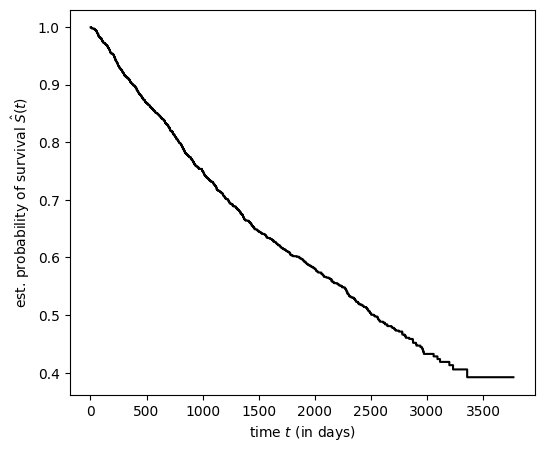

In [9]:
%pip install scikit-survival

# (de Kamps, 2023)
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100  # 200 e.g. is really fine, but slower

timedeath = df['TimeDeath']
timedeath[target < 1.]

statusdeath = [x > 0. for x in target]
time, survival_prob = kaplan_meier_estimator(statusdeath, df['TimeDeath'])

plt.figure(figsize=(6, 5))
plt.step(time, survival_prob, where="post", color="black")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (in days)")
plt.show()

Let's bring the event data into the stuctured array that sksurv expects. `(de Kamps, 2023)`

In [109]:
# (de Kamps, 2023)
import numpy as np

# Set random seed for reproducibility later
np.random.seed(42)

events = [ True if x > 0. else False for x in target]
times  = [ x for x in df['TimeDeath'] ]

data_y = np.array(list(zip(events,times)), dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
print(data_y)

[( True, 1961.) ( True, 2842.) ( True,  749.) ... (False,  652.)
 (False,  652.) (False,  760.)]


Let us now use the other covariates as mentioned by `Mbotwa et al. (2021)`.

In [11]:
print(f"Missing values in ClinicAge: {df['ClinicAge'].isna().sum()}")
print(f"Missing values in Haemoglobin: {df['Haemoglobin'].isna().sum()}")

Missing values in ClinicAge: 0
Missing values in Haemoglobin: 6


We can impute the missing values for `Haemoglobin` with the mean value. `(de Kamps, 2023)`

In [12]:
# (de Kamps, 2023)
data_x_withnan = df[['ClinicAge', 'Haemoglobin']]
data_x_numeric = data_x_withnan.fillna(data_x_withnan.mean())

print(data_x_numeric)
print(data_x_numeric.shape)

      ClinicAge  Haemoglobin
0          75.0         15.5
1          72.0         13.8
2          70.0         13.4
3          55.0         16.6
4          68.0         15.3
...         ...          ...
1797       83.0         13.7
1798       51.0         13.6
1799       72.0         15.7
1800       65.0         13.7
1801       87.0         12.6

[1802 rows x 2 columns]
(1802, 2)


As expected, there are no more missing values.

In [13]:
print(f"Missing values in ClinicAge: {data_x_numeric['ClinicAge'].isna().sum()}")
print(f"Missing values in Haemoglobin: {data_x_numeric['Haemoglobin'].isna().sum()}")

Missing values in ClinicAge: 0
Missing values in Haemoglobin: 0


In [14]:
# (de Kamps, 2023)
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [15]:
estimator.score(data_x_numeric, data_y)

0.666426027639768

OK, let's add `Diabetes` and see if this improves the score `(de Kamps, 2023)`. No problem with missing values: 

In [16]:
print(df['Diabetes'].isna().sum())

0


In [17]:
# (de Kamps, 2023)
data_x_withnan3 = df[['ClinicAge', 'Haemoglobin', 'Diabetes']]
data_x_numeric3 = data_x_withnan3.fillna(data_x_withnan3.mean())
estimator3 = CoxPHSurvivalAnalysis()
estimator3.fit(data_x_numeric3, data_y)
estimator3.score(data_x_numeric3, data_y)

0.670451749959191

Now let's add gender. `(de Kamps, 2023)`

In [18]:
# (de Kamps, 2023)
data_x_withnan4 = df[['ClinicAge', 'Haemoglobin', 'Diabetes', 'MaleSex']]
data_x_numeric4 = data_x_withnan4.fillna(data_x_withnan4.mean())
data_x_withnan4

C:\Users\omarc\AppData\Local\Temp\ipykernel_31816\1893549089.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_x_numeric4 = data_x_withnan4.fillna(data_x_withnan4.mean())


,ClinicAge,Haemoglobin,Diabetes,MaleSex
0,75.0,15.5,0.0,Male
1,72.0,13.8,0.0,Female
2,70.0,13.4,0.0,Male
3,55.0,16.6,0.0,Male
4,68.0,15.3,0.0,Male
...,...,...,...,...
1797,83.0,13.7,0.0,Male
1798,51.0,13.6,1.0,Male
1799,72.0,15.7,0.0,Male
1800,65.0,13.7,0.0,Male


The OneHotEncoder converts categorical data into numerical ones. `(de Kamps, 2023)`

In [19]:
# (de Kamps, 2023)
from sksurv.preprocessing import OneHotEncoder

data_x_numeric4oh = OneHotEncoder().fit_transform(data_x_numeric4)
data_x_numeric4oh.head()

c:\Users\omarc\OneDrive - University of Leeds\Year 3\3931 Individual Project\Code\.venv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


,ClinicAge,Haemoglobin,Diabetes,MaleSex=Male
0,75.0,15.5,0.0,1.0
1,72.0,13.8,0.0,0.0
2,70.0,13.4,0.0,1.0
3,55.0,16.6,0.0,1.0
4,68.0,15.3,0.0,1.0


In [20]:
# (de Kamps, 2023)
estimator4 = CoxPHSurvivalAnalysis()
estimator4.fit(data_x_numeric4oh, data_y)
estimator4.score(data_x_numeric4oh, data_y)

0.679573425174674

Out of interest, what are the coefficients? `(de Kamps, 2023)`

In [21]:
# (de Kamps, 2023)
print(estimator4.coef_)

[ 0.04359563 -0.19889853  0.30170977  0.56861131]


In [22]:
# (de Kamps, 2023)
from sksurv.linear_model import CoxnetSurvivalAnalysis

estimatorlasso = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True)
estimatorlasso.fit(data_x_numeric4oh, data_y)
estimatorlasso.score(data_x_numeric4oh, data_y)

0.6795952666150136

In [23]:
# (de Kamps, 2023)
from sksurv.svm import FastSurvivalSVM

estimatorsvm = FastSurvivalSVM(max_iter=1000, optimizer="rbtree", tol=1e-5, random_state=0)
estimatorsvm.fit(data_x_numeric4oh, data_y)
estimatorsvm.score(data_x_numeric4oh, data_y)

0.679901046779767

### Preliminary Conclusion

`SVM`, `CPH` and `CPH` with `Lasso` all seem to give similar results. We still have to do *cross validation*. `(de Kamps, 2023)`

In [24]:
from sklearn.model_selection import cross_val_score

scores4 = cross_val_score(estimator4, data_x_numeric4oh, data_y, cv=10)
scoreslasso = cross_val_score(estimatorlasso, data_x_numeric4oh, data_y, cv=10)
scoresvm = cross_val_score(estimatorsvm, data_x_numeric4oh, data_y, cv=10)

# Compare results
print(f"Mean score CoxPH: {scores4.mean():.3f} (std: {scores4.std():.3f})")
print(f"Mean score Lasso: {scoreslasso.mean():.3f} (std: {scoreslasso.std():.3f})")
print(f"Mean score SVM: {scoresvm.mean():.3f} (std: {scoresvm.std():.3f})")

Mean score CoxPH: 0.678 (std: 0.037)
Mean score Lasso: 0.678 (std: 0.036)
Mean score SVM: 0.677 (std: 0.037)


## Implementation of the partial likelihood as a loss function

This is dual purpose. We can do a standard CPH regresssion and see if we agree on the result, but as a loss function it is also the output layer of `CoxNNet`, so if it works, it shouldn't be hard to implement that network. `(de Kamps, 2023)`

The log partial likelihood is given by:
$$
\ln L_{\boldsymbol{\beta}} = \sum^N_{i=1} c_i( \theta_i - \ln \sum_{j \in R(t_j)} \exp \theta_j)
$$

When we allow for tied events, the procedure needs to be adapted. There are two main approaches, one by `Breslow` and one by `Efron`. Most survival analysis packages include at least these two methods. We will implement the `Breslow` one to ensure we understand the procedure, but will use `sksurv`'s implementation in the loss function. 

If $s_j=\sum_{i  \in D_j} \boldsymbol{x}_i$ is the sum of covariates over the set $D_j$ of individuals who die at time $t_j$, then
$$
L_{\boldsymbol{\beta}} = \frac{\Pi^J_{j=1} \exp \boldsymbol{\beta} \boldsymbol{s}_j}{ \left\{ \sum_{k \in R_j} \exp \boldsymbol{\beta} \boldsymbol{x}_k   \right\}^{d_j}}
$$

If we look at the file `coxph.py` we see that `CoxPHOptimizer` implements this likelihood.

**Note**: We have adapted this function instead of duplicating it further down to take in a `model` if specified by `CoxNNet`.

In [25]:
import torch 

# Sets the random seed for generating random numbers in the future
torch.manual_seed(42)

import numpy

# Adapted from Pölsterl (2023); de Kamps (2023)

class CoxPHOptimizer:
    """Negative partial log-likelihood of Cox proportional hazards model."""

    def __init__(self, X, event, time, alpha, ties):
        """Initialize the model.

        Args:
            X (pandas.DataFrame): The dataset.
            event (array): List of events.
            time (array): List of times.
            alpha (array): List of L2 penalties for each coefficient.
            ties (string): Which method to use for ties. One of 'breslow' or 'efron'.

        Raises:
            ValueError: If ties is not one of 'breslow' or 'efron'.
        """
        # Sort descending
        o = numpy.argsort(-time, kind="mergesort")
        self.x = torch.tensor(X[o, :], dtype=torch.float)
        self.event = event[o]
        self.time = time[o]
        self.alpha = alpha
        # Method to handle ties
        if ties not in ("breslow", "efron"):
            raise ValueError("ties must be one of 'breslow', 'efron'")
        ties = "breslow"
        self._is_breslow = ties == "breslow"

    def nlog_likelihood(self, w=None, model=None):
        """Compute negative partial log-likelihood.

        Args:
            w (array, shape = (n_features,), optional): Estimate of coefficients. Defaults to None.
            model (torch.nn.Module, optional): The NN model. Defaults to None.

        Returns:
            float: Average negative partial log-likelihood (NPLL per event).
        """
        time = self.time
        n_samples = self.x.shape[0]
        breslow = self._is_breslow
        xw = []
                
        if model is not None:
            for i in range(n_samples):
                # Computes risk score for each sample using the NN model
                # and appends it to the list xw, containing the risk scores for all samples.
                xw.append(model.forward(self.x[i]))
        else:
            # This is the critical line of code for our project. 
            # It is the matrix-vector product of the matrix of features x
            # and the vector of weights w.
            # This is what we will be replacing with our NNs.
            # As seen above, when the model is not None, we use the NN model.
            xw = self.x@w

        loss = 0
        risk_set = 0
        k = 0
        
        while k < n_samples:
            ti = time[k]
            numerator = 0
            n_events = 0
            risk_set2 = 0
            while k < n_samples and ti == time[k]:
                if self.event[k]:
                    numerator = numerator + xw[k]
                    risk_set2 = risk_set2 + torch.exp(xw[k])
                    n_events = n_events + 1
                else:
                    risk_set = risk_set + torch.exp(xw[k])
                k = k + 1

            if n_events > 0:
                if breslow:
                    risk_set = risk_set + risk_set2
                    loss = loss - (numerator - n_events * torch.log(risk_set)) / n_samples
                else:
                    numerator = numerator/n_events
                    for _ in range(n_events):
                        risk_set = risk_set + risk_set2 / n_events
                        loss = loss - (numerator - torch.log(risk_set)) / n_samples

        return loss
    
    def update(self, model, offset=0):
        """Compute and updates gradient and Hessian matrix.
        
        Args:
            model (torch.nn.Module): The NN model.
            offset (float, optional): The offset. Defaults to 0.
        """
        # Note that in this function, we do not use coefficients
        # Thus we do not pass in the weights `w`
        time = self.time
        x = self.x
        breslow = self._is_breslow
        n_samples, n_features = x.shape
        
        # Compute risk score for each sample using the NN model
        # Everything else in this function is the same as the original code
        exp_xw = []
        for i in range(n_samples):
            exp_xw.append(np.exp(offset + model.forward(torch.tensor(x[i], dtype=torch.float32)).item()))

        gradient = numpy.zeros((1, n_features), dtype=numpy.float64)
        hessian = numpy.zeros((n_features, n_features), dtype=numpy.float64)

        inv_n_samples = 1. / n_samples
        risk_set = 0
        risk_set_x = numpy.zeros((1, n_features), dtype=numpy.float64)
        risk_set_xx = numpy.zeros((n_features, n_features), dtype=numpy.float64)
        k = 0
        
        # Iterate time in descending order
        while k < n_samples:
            ti = time[k]
            n_events = 0
            numerator = 0
            risk_set2 = 0
            risk_set_x2 = numpy.zeros_like(risk_set_x)
            risk_set_xx2 = numpy.zeros_like(risk_set_xx)
            while k < n_samples and ti == time[k]:
                # Preserve 2D shape of row vector
                xk = x[k:k + 1]

                # Outer product
                xx = numpy.dot(xk.T, xk)

                if self.event[k]:
                    numerator += xk
                    risk_set2 += exp_xw[k]
                    risk_set_x2 += exp_xw[k] * xk
                    risk_set_xx2 += exp_xw[k] * xx
                    n_events += 1
                else:
                    risk_set += exp_xw[k]
                    risk_set_x += exp_xw[k] * xk
                    risk_set_xx += exp_xw[k] * xx
                k += 1

            if n_events > 0:
                if breslow:
                    risk_set += risk_set2
                    risk_set_x += risk_set_x2
                    risk_set_xx += risk_set_xx2

                    z = risk_set_x / risk_set
                    gradient -= (numerator - n_events * z) * inv_n_samples

                    a = risk_set_xx / risk_set
                    # outer product
                    b = numpy.dot(z.T, z)

                    hessian += n_events * (a - b) * inv_n_samples
                else:
                    numerator /= n_events
                    for _ in range(n_events):
                        risk_set += risk_set2 / n_events
                        risk_set_x += risk_set_x2 / n_events
                        risk_set_xx += risk_set_xx2 / n_events

                        z = risk_set_x / risk_set
                        gradient -= (numerator - z) * inv_n_samples

                        a = risk_set_xx / risk_set
                        # outer product
                        b = numpy.dot(z.T, z)

                        hessian += (a - b) * inv_n_samples

        self.gradient = gradient.ravel()
        self.hessian = hessian
    
    def zero(self):
        """Reset gradient and Hessian matrix."""
        self.gradient = 0
        self.hessian = 0

### Verification

An independent check on the numbers would be handy. [John Fox introductory course on survival analysis](https://socialsciences.mcmaster.ca/jfox/Courses/soc761/survival-analysis.pdf), provides a numerical example. The advantage of that example is that we get to see which coefficient belongs to what covariate. `(de Kamps, 2023)`

In [26]:
%pip install lifelines

# (de Kamps, 2023)
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

rossi = load_rossi()

cph = CoxPHFitter().fit(rossi, 'week', 'arrest')

cph.print_summary(columns=["coef", "se(coef)", "p"])

Note: you may need to restart the kernel to use updated packages.


<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2023-04-25 02:47:33 UTC

---
            coef   se(coef)      p
covariate                         
fin        -0.38       0.19   0.05
age        -0.06       0.02   0.01
race        0.31       0.31   0.31
wexp       -0.15       0.21   0.48
mar        -0.43       0.38   0.26
paro       -0.08       0.20   0.66
prio        0.09       0.03 <0.005
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

OK, that was a bit quick. What happened here? `Lifelines` is another survival package. It was just one line to do CPH fit and the coefficients are almost identical to the example given by Fox (slide `76`). `(de Kamps, 2023)`

At the very least, we should redo the analysis with `sksurv`. `rossi` is a dataframe that is understood by `Pandas`.

In [27]:
rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [28]:
# (de Kamps, 2023)
events = [True if x > 0. else False for x in rossi['arrest']]
times = [x for x in rossi['week']]

data_y_rossi = np.array(list(zip(events, times)), dtype=[('Status', '?'), ('Survival_in_weeks', '<f8')])

data_x_rossi = rossi[['fin','age','race','wexp','mar','paro','prio']]
data_x_rossi.head()

,fin,age,race,wexp,mar,paro,prio
0,0,27,1,0,0,1,3
1,0,18,1,0,0,1,8
2,0,19,0,1,0,1,13
3,1,23,1,1,1,1,1
4,0,19,0,1,0,1,3


In [29]:
# (de Kamps, 2023)
estimatorrossi = CoxPHSurvivalAnalysis()
estimatorrossi.fit(data_x_rossi, data_y_rossi)
score = estimatorrossi.score(data_x_rossi, data_y_rossi)
print('Estimator score is:', score)
print('Coefficients:', estimatorrossi.coef_)

Estimator score is: 0.6404231835047672
Coefficients: [-0.37902189 -0.05724593  0.31412977 -0.1511146  -0.43278257 -0.08498284
  0.09111154]


Again, very similar results to Fox's table and importantly, the order of the coefficients is given by the order of the covariates. `(de Kamps, 2023)`

Now let's go back for to the CHF data for a bit and see whether the lifelines analysis produces the same coefficients.

In [30]:
# (de Kamps, 2023)
data_chf = df[['StatusDeath', 'TimeDeath', 'ClinicAge', 'Haemoglobin', 'Diabetes', 'MaleSex']]
data_chf_imputed = data_chf.fillna(data_chf.mean())
data_chf_numeric = OneHotEncoder().fit_transform(data_chf_imputed)
print(data_chf_numeric.head())

# Let us use a simpler variable name
chf = data_chf_numeric

C:\Users\omarc\AppData\Local\Temp\ipykernel_31816\2931472563.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_chf_imputed = data_chf.fillna(data_chf.mean())
c:\Users\omarc\OneDrive - University of Leeds\Year 3\3931 Individual Project\Code\.venv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


In [31]:
# (de Kamps, 2023)
cphchf = CoxPHFitter().fit(chf, 'TimeDeath', 'StatusDeath')
cphchf.print_summary(columns=["coef", "se(coef)", "p"])

# Store the coefficients
cphchf_coef = cphchf.summary['coef']

<lifelines.CoxPHFitter: fitted with 1802 total observations, 1065 right-censored observations>
             duration col = 'TimeDeath'
                event col = 'StatusDeath'
      baseline estimation = breslow
   number of observations = 1802
number of events observed = 737
   partial log-likelihood = -4949.39
         time fit was run = 2023-04-25 02:47:34 UTC

---
               coef   se(coef)      p
covariate                            
ClinicAge      0.04       0.00 <0.005
Haemoglobin   -0.20       0.02 <0.005
Diabetes       0.30       0.08 <0.005
MaleSex=Male   0.57       0.09 <0.005
---
Concordance = 0.68
Partial AIC = 9906.77
log-likelihood ratio test = 329.17 on 4 df
-log2(p) of ll-ratio test = 230.07

They are almost the same coefficients, and in the same order. `(de Kamps, 2023)`

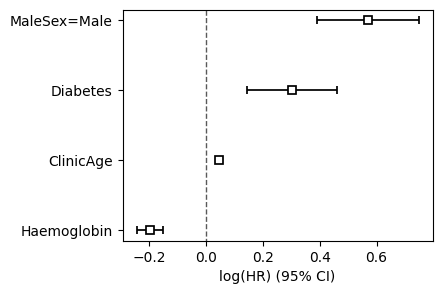

In [32]:
# Plot the coefficients
plt.figure(figsize=(4, 3))
cphchf.plot()
plt.show()

In [33]:
# Prepare the data for the CoxPHSurvivalAnalysis
eventschf = [True if x > 0. else False for x in chf['StatusDeath']]
timeschf = [x for x in chf['TimeDeath']]
data_y_chf = np.array(list(zip(eventschf, timeschf)), dtype=[('Status', '?'), ('Survival_in_weeks', '<f8')])
data_x_chf = chf[['ClinicAge', 'Haemoglobin', 'Diabetes', 'MaleSex=Male']]

# Do the same for the CoxPHSurvivalAnalysis on CHF
estimatorchf = CoxPHSurvivalAnalysis()
estimatorchf.fit(data_x_chf, data_y_chf)
score = estimatorchf.score(data_x_chf, data_y_chf)
print('Estimator score is:', score)
print('Coefficients:', estimatorchf.coef_)

Estimator score is: 0.679573425174674
Coefficients: [ 0.04359563 -0.19889853  0.30170977  0.56861131]


## Neural Network Implementation of Partial Regression

OK, we have a free floating loss function, as yet not really tested. It's not even a loss function as such, more a methodology. Let's tidy up. `(de Kamps, 2023)`

In [34]:
# Adapted from de Kamps (2023); Ching et al. (2018)
# We allow pasing in a model when computing the log-likelihood

torch.autograd.set_detect_anomaly = True

class CoxNNet(torch.nn.Module):
    """CoxNNet model for survival analysis."""

    def __init__(self, df, event, time, coefficients=None):
        """Initialize the CoxNNet model.

        Args:
            df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
            event (str): Name of the event column. 
            time (str): Name of the time column.
            coefficients (torch.tensor, optional): Initial coefficients. Defaults to None.
        """

        super().__init__()

        self.covariates = [x for x in df.columns if x != event and x != time]
        self.df = df
        self.dfx = df[self.covariates].to_numpy(dtype=float)
        
        n_covariates = len(self.covariates)
        
        # If no coefficients are passed in, we initialize them randomly
        if coefficients == None:
            self.coefficients = torch.randn(n_covariates, requires_grad=True, dtype=torch.float)
        # Otherwise we use the coefficients passed in
        else:
            self.coefficients = coefficients.clone().detach().requires_grad_(True)
        # print(self.coefficients)
        
        # This line is used in coxpy to initialize the alphas
        alphas = torch.zeros(self.dfx.shape[1])
        
        self.opt = CoxPHOptimizer(self.dfx, self.df[event].to_numpy(),
                                  self.df[time].to_numpy(),
                                  alphas, 'breslow')

    def forward(self, model=None):
        """Calculate the log-likelihood over the entire dataset.
        This is the function that is called when we call net.forward().
        Important: this is where we can pass in a NN model.

        Args:
            model (torch.nn.Module, optional): NN model to use. Defaults to None.

        Returns:
            float: Log-likelihood over the entire dataset.
        """
        # sksurv calculates the llh /event and puts a minus sign in front, we undo that
        total = -self.df.shape[0]*self.opt.nlog_likelihood(self.coefficients, model)
        return total

# Simply testing to make sure the code works
c = torch.tensor([-0.38, -0.06, 0.31, -0.15, -0.43, -0.08, 0.09])
net = CoxNNet(rossi, 'arrest', 'week', coefficients=c)
net.forward()

tensor(-659.1310, grad_fn=<MulBackward0>)

This is nearly identical to `lifelines` estimate. `(de Kamps, 2023)`

We can do the same for the `CHF` data.

In [35]:
chf_c = torch.tensor([0.04, -0.20, 0.30, 0.57], requires_grad=True)
chf_net_c = CoxNNet(chf, 'StatusDeath', 'TimeDeath', coefficients=chf_c)
chf_net_c.forward()

tensor(-4949.9800, grad_fn=<MulBackward0>)

### Gradient Descent

We will use the `autograd` functionality provided by `PyTorch` to do the differentiation to maximise the partial log-likelihood.

In [36]:
# Adapted from de Kamps (2023)
def gradient_descent(df, event, time, lr, n_epoch, coefficients=None):
    """Performs gradient descent on the Cox model.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        lr (float): Learning rate.
        n_epoch (int): Number of epochs (iterations to run).
        coefficients (torch.tensor, optional): _description_. Defaults to None.

    Returns:
        torch.nn.Module: The trained CoxNNet model (with updated coefficients).
    """
    net = CoxNNet(df, event, time, coefficients)
    loss = net.forward()
    print(loss)
    
    # Iterate n_epoch times
    for _ in range(n_epoch):
        # Updates the coefficients using autograd
        loss = net.forward()
        loss.backward()
        with torch.no_grad():
            # Use the specified learning rate
            net.coefficients += net.coefficients.grad * lr
            net.coefficients.grad.zero_()
    loss = net.forward()
    
    # Print the final loss and the updated coefficients
    print(loss)
    print(net.coefficients)
    return net

rossi_net = gradient_descent(rossi, 'arrest', 'week', 0.0001, 4000)

tensor(-3214.1331, grad_fn=<MulBackward0>)
tensor(-659.1335, grad_fn=<MulBackward0>)
tensor([-0.3797, -0.0569,  0.3044, -0.1431, -0.4941, -0.0826,  0.0914],
       requires_grad=True)


Since the values found by `CoxNNet` for the coefficients appear close to the lifelines results, it appears we have successfully used `PyTorch` to calculate a gradient for the loss function and perform *steepest gradient descent*. Let's test on the `CHF` dataset.

In [37]:
# Note: this takes a while to run
# We tried to use the same learning rate (i.e. 0.0001) but that did not work
# Thus, we used a smaller learning rate (i.e. 0.000001)
chf_net = gradient_descent(chf, 'StatusDeath', 'TimeDeath', 0.000001, 4000)

tensor(-25610.7988, grad_fn=<MulBackward0>)
tensor(-4949.5996, grad_fn=<MulBackward0>)
tensor([ 0.0435, -0.1968,  0.3059,  0.5315], requires_grad=True)


Again, same results. We should probably also create a gradient descent method for training NN models.

### Gradient Descent for Neural Network Models

In [45]:
# Train the NN using gradient descent
def train_model(df, event, time, model, lr, n_epoch, output=False):
    """Trains a NN model using gradient descent.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        model (_type_): NN model.
        lr (float): Learning rate.
        n_epoch (int): Number of epochs (iterations to run).
        output (bool, optional): Whether to print the loss before and after training. Defaults to True.
        
    Returns:
        float: The final loss.
    """
    net = CoxNNet(df, event, time)
    losses = []
    
    # Print the initial loss
    if output:
        print("Loss before training:", net.forward(model))
    
    # Train the model
    for _ in range(n_epoch):
        # Compute the loss using the CoxNNet class and the NN model
        loss = net.forward(model)
        loss.backward()        
        losses.append(loss)
        
        # Update the weights using gradient descent
        with torch.no_grad():
            for param in model.parameters():
                param += param.grad * lr
            model.zero_grad()
    
    # Print the final loss
    if output:
        print("Loss after training:", net.forward(model))
        
        # Produce a plot of the loss over the epochs
        losses = [x.detach().numpy() for x in losses]
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, n_epoch+1), losses, color='black')
        plt.xlabel('Epochs')
        plt.ylabel('Negative Partial Log-Likelihood Loss')
        plt.show()
    
    # Return the final PLE loss of the final trained model
    return losses[-1]

We can test this later. For now, let's use a way to measure the performance of the model.

## Concordance Statistics

The *concordance statistic* (also known as the c-statistic) is a measure of the goodness of fit of a survival model. It quantifies the model's ability to correctly order the predicted survival times of pairs of individuals. A higher c-statistic indicates a better model fit. Here's how to compute the c-statistic given a set of survival times and a set of predicted survival times:

In [46]:
def concordance_statistic(risks, events, times):
    """Calculates the c-statistic for a given set of predicted risks and actual events and times.

    Args:
        risks (array): List of predicted risks.
        events (array): List of event indicators.
        times (array): List of survival times.

    Returns:
        float: c-statistic.
    """
    valid_pairs = 0
    concordant_pairs = 0
    discordant_pairs = 0
    tied_pairs = 0

    n_samples = len(risks)
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if times[i] != times[j]:
                if events[i] and (times[i] < times[j]):
                    valid_pairs += 1
                    if risks[i] > risks[j]:
                        concordant_pairs += 1
                    elif risks[i] < risks[j]:
                        discordant_pairs += 1
                    else:
                        tied_pairs += 1

                elif events[j] and (times[j] < times[i]):
                    valid_pairs += 1
                    if risks[j] > risks[i]:
                        concordant_pairs += 1
                    elif risks[j] < risks[i]:
                        discordant_pairs += 1
                    else:
                        tied_pairs += 1

    # Note we do not actually need to use discordant_pairs in the calculation
    # Since we already increment valid_pairs when we encounter a discordant pair
    return (concordant_pairs + 0.5 * tied_pairs) / valid_pairs

This code snippet defines a `concordance_statistic` function that calculates the c-statistic given the predicted risks, event indicators, and survival times. The function iterates through all valid pairs of individuals and counts the number of concordant, discordant, and tied pairs. The c-statistic is then calculated as the ratio of the sum of concordant pairs and half the tied pairs to the total number of valid pairs.

After defining the function, the predicted risks for each individual in the dataset are calculated by multiplying the covariate matrix `net.dfx` with the optimized model coefficients. The c-statistic is then computed using the `concordance_statistic` function, and the result is printed.

We can define another function `get_concordance` that takes in a `CoxNNet` model, a dataframe, an event and a time, and returns the c-statistic.

In [47]:
def get_concordance_statistic(df, event, time, net):
    """Calculates the c-statistic for a given dataset for the CoxNNet model.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        net (torch.nn.Module): CoxNNet model.

    Returns:
        float: c-statistic.
    """
    # Calculate the predicted risk for each individual in the dataset
    risks = np.matmul(net.dfx, net.coefficients.detach().numpy())
    
    return concordance_statistic(risks, df[event].to_numpy(), df[time].to_numpy())

print("Base Rossi c-statistic:", get_concordance_statistic(rossi, 'arrest', 'week', rossi_net))

Base Rossi c-statistic: 0.643355119825708


This is the same c-statistic as the one used by `lifelines` for the `Rossi` dataset.

### Concordance Statistic for Neural Network Models

Now, let us adapt the `get_concordance_statistic` to allow for a NN model. We need to compute the risk for an invidual using the NN model, instead of computing the dot product using the coefficients.

In [48]:
# Calculate the predicted risk for each individual in the dataset
def get_concordance_statistic_nn(df, event, time, model):
    """Calculates the c-statistic for a given dataset using a NN model to compute predicted risks.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        model (torch.nn.Module): NN model.

    Returns:
        float: c-statistic.
    """
    # Calculate the predicted risk for each individual in the dataset using the NN
    x = torch.tensor(df[[col for col in df.columns if col not in [event, time]]].values, dtype=torch.float)    
    with torch.no_grad():
        predicted_risk = np.array([model.forward(xi).item() for xi in x])
    
    # Compute the c-statistic
    return concordance_statistic(predicted_risk, df[event].to_numpy(), df[time].to_numpy())

Let us test this on a simple NN which is essentially the same as the CPH model.

In [49]:
# This NN essentially computes the same as the CoxPH model
# i.e. xw = self.x@w = x1w1 + x2w2 + x3w3 + x4w4 + ... + xnw_n
# This is computed in the forward pass
# We call it linear because it is a linear model, i.e. it is a linear combination of the covariates
# and does not have any hidden layers, thus not capturing any non-linear relationships.
class FixedWeightLinear(torch.nn.Module):
    """Simple NN with no hidden layers that simply computes the dot product of the input and the weights.
    This is essentially the same as the CoxPH model.
    We do not train this model, we simply use it to compute the predicted risk for each individual in the dataset.
    """
    
    def __init__(self, weights):
        """Initializes the FWL model.

        Args:
            weights (torch.tensor): Weights to use for the dot product.
        """
        super(FixedWeightLinear, self).__init__()
        # Initialize the weights as a torch.nn.Parameter
        self.weights = torch.nn.Parameter(weights.clone().detach().requires_grad_(True))

    def forward(self, x):
        """Simply multiply the weights by the input.

        Args:
            x (array): List of covariates for a single individual.

        Returns:
            float: Predicted risk.
        """
        return torch.matmul(x, self.weights)
    
# Initialize the FWL model with the learned coefficients
rossi_fwl = FixedWeightLinear(rossi_net.coefficients)

# Compute the c-statistic using the FWL model
print("FWL Rossi c-statistic:", get_concordance_statistic_nn(rossi, 'arrest', 'week', rossi_fwl))

FWL Rossi c-statistic: 0.643355119825708


We acheieve the same c-statistic. As we have seen we have been able to reproduce coefficients and the c-statistic scores, we have everything needed to begin building NNs.

## Neural Network Exploration

First, we will begin by adapting the `FixedWeightLinear` NN so that we may use random weights. We will need to be able to train the model with random weights, and then use the optimizer to find the best weights.

In [50]:
# This class lets us use random weights for each feature
class VariableWeightLinear(FixedWeightLinear):
    """Simple NN with no hidden layers that simply computes the dot product of the input and the weights.
    However, the weights are randomly initialized and then trained using gradient descent."""
    
    def __init__(self, n):
        """Initializes the VWL model.

        Args:
            n (int): Number of features in the dataset.
        """
        # Randomise weights
        weights = torch.nn.Parameter(torch.randn(n, requires_grad=True, dtype=torch.float))
        super(VariableWeightLinear, self).__init__(weights)
        # Print these initial weights
        print("Initial VWL", self.weights)

    def forward(self, x):
        """Simply multiply the weights by the input.

        Args:
            x (array): List of covariates for a single individual.

        Returns:
            float: Predicted risk.
        """
        # Again, simply multiply the weights by the input
        return torch.matmul(x, self.weights)
    
# Initialize the VariableWeightLinear model
n_covariates = len([x for x in rossi.columns if x != 'arrest' and x != 'week'])
rossi_vwl = VariableWeightLinear(n_covariates)

# Compute the c-statistic using the trained VWL model
print("Initial VWL Rossi C-Statistic:", get_concordance_statistic_nn(rossi, 'arrest', 'week', rossi_vwl))

Initial VWL Parameter containing:
tensor([ 0.0562,  0.5227, -0.2384, -0.0499,  0.5263, -0.0085,  0.7291],
       requires_grad=True)
Initial VWL Rossi C-Statistic: 0.4784555797627693


Let us now train this model. The goal is to produce the same weights as the CPH model.

In [51]:
# Train the model using the train_model function we created before
rossi_vwl_loss = train_model(rossi, 'arrest', 'week', rossi_vwl, 0.0001, 4000, False)

# Compute the c-statistic using the trained VWL model
rossi_vwl_c = get_concordance_statistic_nn(rossi, 'arrest', 'week', rossi_vwl)

# Print the trained weights and loss in format string
print("Trained VWL Rossi Weights: {0} \
      \nTrained VWL Rossi Loss: {1} \
      \nTrained VWL Rossi c-statistic {2}"
      .format(rossi_vwl.weights, rossi_vwl_loss, rossi_vwl_c))

Trained VWL Rossi Weights: Parameter containing:
tensor([-0.3781, -0.0575,  0.3143, -0.1575, -0.3911, -0.0865,  0.0909],
       requires_grad=True)       
Trained VWL Rossi Loss: -659.126708984375       
Trained VWL Rossi c-statistic 0.643839264100702


We can see that the weights are very close to the CPH model. Now we can begin experimenting with different NN architectures.

### Single Hidden Layer

This simple NN class allows us to experiment with the number of neurons in a single hidden layer.

In [52]:
class SNN(torch.nn.Module):
    """Simple NN with one hidden layer."""
    
    def __init__(self, input_size, hidden_size):
        """Initializes the SNN model.

        Args:
            input_size (int): Number of covariates.
            hidden_size (int): Number of neurons in the hidden layer.
        """
        super(SNN, self).__init__()
        # Store the input and hidden sizes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, 1)
        self.model = torch.nn.Sequential(self.fc1, self.relu, self.fc2)

    def forward(self, x):
        """Predicts the risk for a single individual.

        Args:
            x (array): List of covariates for a single individual.

        Returns:
            float: Predicted risk.
        """
        return self.model(x)
    
    def return_weights(self):
        """Returns the weights of the model all in one numpy array.

        Returns:
            array: Weights of the model.
        """
        return torch.cat([self.fc1.weight.view(-1), self.fc1.bias, self.fc2.weight.view(-1), self.fc2.bias]).detach().numpy()

Now let's create a class which we can use in the future to help test this model, and other models in the future.

Loss before training: tensor([-701.0788], grad_fn=<MulBackward0>)
Loss after training: tensor([-657.0486], grad_fn=<MulBackward0>)


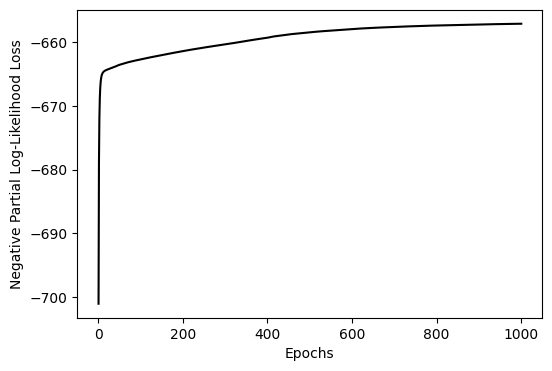

SNN[7, 49, 1] 
- Loss: [-657.04987]
- Score: 0.6470104091019123


(array([-657.04987], dtype=float32), 0.6470104091019123)

In [53]:
# This allows us to test different architectures of the `NN` model
def test_nn(df, event, time, model, lr, n_epoch, output=False):
    """Trains the model and prints the c-statistic.

    Args:
        df (pandas.DataFrame): Dataset to use.
        event (str): Name of the event column.
        time (str): Name of the time column.
        model (torch.nn.Module): NN model.
        lr (float): Learning rate.
        n_epoch (int): Number of epochs.
        output (bool, optional): Whether to print the output. Defaults to False.
    """
    loss = train_model(df, event, time, model, lr, n_epoch, output)
    score = get_concordance_statistic_nn(df, event, time, model)
    if output:
        # Print format string with loss and score
        if type(model).__name__ == "SNN":
            param = f"[{model.input_size}, {model.hidden_size}, 1]"
        elif type(model).__name__ == "GNN": # This will be useful later
            param = model.layer_sizes
        print(f"{type(model).__name__}{param} \n- Loss: {loss}\n- Score: {score}")
    return loss, score

# Test the simple model on the Rossi data set
input_size = rossi.shape[1] - 2  # Number of input features (excluding censor and time variables)
hidden_size = input_size * input_size  # Number of hidden units
rossi_snn = SNN(input_size, hidden_size)
test_nn(rossi, 'arrest', 'week', rossi_snn, 0.0001, 1000, True)

This worked well. No surprise as the neurons shold easily be able to capture the non-linear relationships. Let's investigate the *architecture* further.

In [55]:
# Create a loop to test different architectures (begin with 1 neuron in single hidden layer, increase in steps of 7 until 70)
rossi_snn_losses = []
rossi_snn_scores = []

# This allows us to test different architectures of the NN model
rossi_snn_hidden_sizes = [7 + i * 7 for i in range(11)]

# This stores the best model and its score
# Note we use 0.5 as the initial score because random predictions have a c-statistic of 0.5
# so we want to make sure we get a better score than that
rossi_snn_best = [None, 0, 0.5]

# Loop through the different architectures
for i in rossi_snn_hidden_sizes:
    model = SNN(input_size, i)
    loss, score = test_nn(rossi, 'arrest', 'week', model, 0.0001, 1000, False)
    if score > rossi_snn_best[2]:
        rossi_snn_best = [model, loss.detach().numpy(), score]
    rossi_snn_losses.append(loss.detach().numpy())
    rossi_snn_scores.append(score)

# Print the scores of the best architecture
print("Best SNN Rossi: \
    \n- Architecture: SNN[{0}, {1}, 1] \
    \n- Loss: {2} \
    \n- Score: {2}"
    .format(input_size, rossi_snn_best[0].hidden_size, rossi_snn_best[1], rossi_snn_best[2]))

Best SNN Rossi:     
- Architecture: SNN[7, 49, 1]     
- Loss: [-662.16516]     
- Score: [-662.16516]


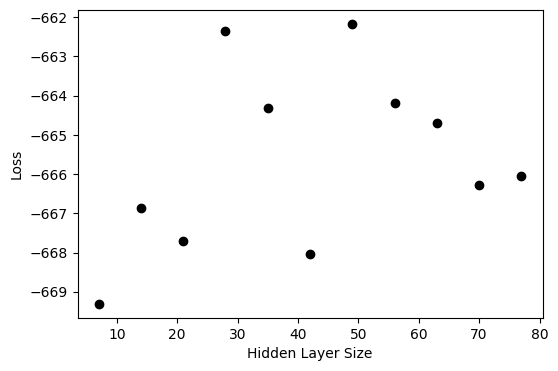

In [69]:
# Plot the losses
plt.figure(figsize=(6, 4))
plt.scatter(rossi_snn_hidden_sizes, rossi_snn_losses, label='Loss', color='black')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Loss')
plt.show()

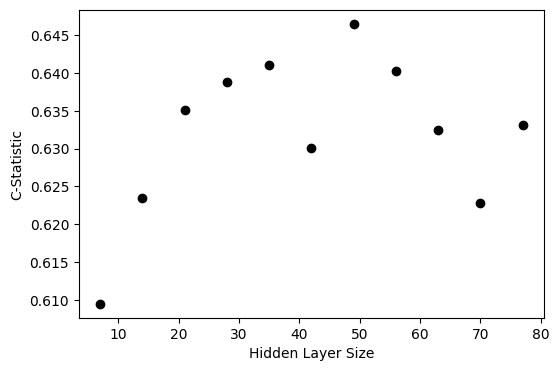

In [71]:
# Plot the c-statistic scores
plt.figure(figsize=(6, 4))
plt.scatter(rossi_snn_hidden_sizes, rossi_snn_scores, label='C-Statistic', color='black')
plt.xlabel('Hidden Layer Size')
plt.ylabel('C-Statistic')
plt.show()

Ok. The graphs indicate that the larger the hidden layer size, the better the model. Let's visualize the weights of the model to see if we have potential overfitting.

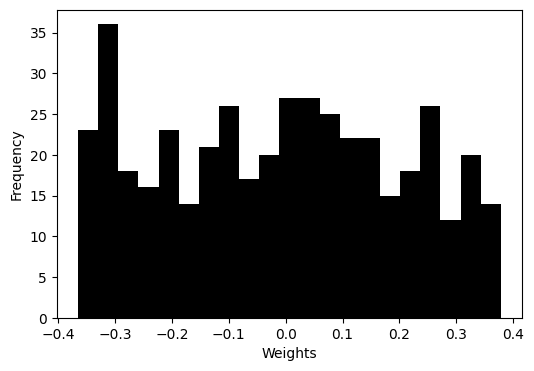

In [73]:
# Use a histogram with n_bins = size of data square root
rossi_snn_weights = rossi_snn_best[0].return_weights()
plt.figure(figsize=(6, 4))
plt.hist(rossi_snn_weights, bins=int(np.sqrt(len(rossi_snn_weights))), color='black')
plt.xlabel('Weights')
plt.ylabel('Frequency')
plt.show()

Interestingly, the weights are quite small. This is a good sign. Instead of using a single hidden layer, let's try using multiple.

### Multiple Hidden Layers

Let us create a more general NN class that allows us to experiment with the number of hidden layers and neurons in each layer.

The goal is to see how the number of parameters affects the performance of the NN.

In [74]:
class GNN(torch.nn.Module):
    """General NN with any number of hidden layers with any number of neurons."""
    
    def __init__(self, layer_sizes):
        """Initializes the GNN model.

        Args:
            layer_sizes (array): List of the number of neurons in each layer.
        """
        super(GNN, self).__init__()
        # We want to store the sizes in a list for the future
        self.layer_sizes = layer_sizes
        # Create a list of layers
        self.layers = torch.nn.ModuleList()
        # Create the layers based on the input sizes
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer
            self.layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            # Add a ReLU activation function after every linear layer except the last one
            if i < len(layer_sizes) - 2:  # Don't add ReLU activation after the last linear layer
                self.layers.append(torch.nn.ReLU())
        self.model = torch.nn.Sequential(*self.layers)

    def forward(self, x):
        """Predicts the risk for a single individual.

        Args:
            x (array): List of covariates for a single individual.

        Returns:
            float: Predicted risk.
        """
        return self.model(x)

    def return_weights(self):
        """Returns the weights of the model all in one numpy array.

        Returns:
            array: Weights of the model.
        """
        weights = []
        for layer in self.layers:
            if type(layer).__name__ == "Linear":
                weights.append(layer.weight.view(-1))
                weights.append(layer.bias)
        return torch.cat(weights).detach().numpy()

This class takes a list of integers as input, where each integer represents the number of neurons in that layer. The first integer is the input size, the last integer should be `1` (as the final output neuron should be `1`), and the integers in between represent the number of neurons in each hidden layer. We can adapt this class to allow us to further experiment with the properties of the NN.

For example, you can create a NN with `2` hidden layers, the first having `5` neurons and the second having `3` neurons:

```python
GNN([7, 5, 3, 1])  # 7 input neurons, 2 hidden layers with 5 and 3 neurons, 1 output neuron
```

We will stick to using `hidden_size` as the number of neurons in the hidden layers as it as a simple architecture that is easy to understand. Tt should capture the relationships of the covariates and not be too complex to overfit the data.

Loss before training: tensor([-668.5838], grad_fn=<MulBackward0>)
Loss after training: tensor([-657.1593], grad_fn=<MulBackward0>)


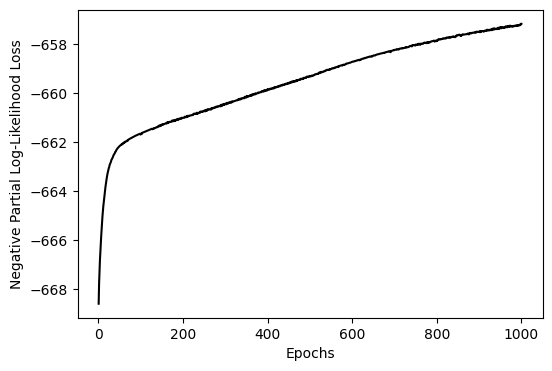

GNN[7, 49, 49, 1] 
- Loss: [-657.1667]
- Score: 0.6497700314693778


(array([-657.1667], dtype=float32), 0.6497700314693778)

In [75]:
# Using the [7, 49, 49, 1] architecture
rossi_gnn = GNN([input_size, hidden_size, hidden_size, 1])
test_nn(rossi, 'arrest', 'week', rossi_gnn, 0.0001, 1000, True)

Interestingly, we see that increasing the number of hidden layers and neurons does not neccessarily produce a better model. This may be due to overfitting, or maybe the neural network can no longer capture any more of the data. Let us again visualise the weights of the model.

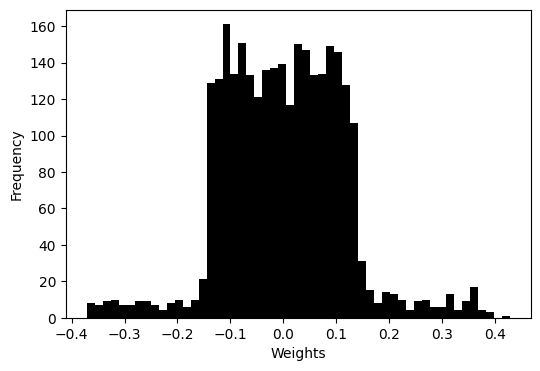

In [76]:
# Visualise weights of the GNN model using a histogram
# We expect there to be exponentially more weights in the GNN model than the SNN model
rossi_gnn_weights = rossi_gnn.return_weights()
plt.figure(figsize=(6, 4))
plt.hist(rossi_gnn_weights, bins=int(np.sqrt(len(rossi_gnn_weights))), color='black')
plt.xlabel('Weights')
plt.ylabel('Frequency')
plt.show()

Again, this is good. The weights do not seem to cause overfitting. 

We considered exploring other methods, including *regularisation*, the number of *epochs*, the *learning rate*, the *activation function*, the *optimizer*, *feature processing*, *ensemble methods* and *early stopping*. However, we will leave this for another time. It is unlikely this will improve performance. It seems the models can only perform so well. Let's investigate the data further.

## Latent Class Analysis

*Latent Class Analysis* (LCA) is a statistical method for identifying hidden subgroups within a population. In the context of our problem, we can use LCA to separate patients into different subgroups and then train separate GNN models for each subgroup.

To create a class for latent class analysis using the CPH model, we can:

1. Split the dataset into a given number of components (latent classes).
2. Train a separate GNN model for each component.
3. Produce the final loss and c-statistic over all components.

### Clustering

To split the data, we can use the `KMeans` clustering algorithm. This algorithm takes in a number of clusters and returns a list of cluster labels for each individual in the dataset. The `KMeans` algorithm is used as the default method in `GuassianMixture`.

In [127]:
%pip install sklearn

from sklearn.mixture import GaussianMixture

class LCA:
    """Latent Class Analysis model for survival analysis."""
    
    def __init__(self, df, event, time, n_components=2):
        self.components = n_components
        self.df = df
        self.event = event
        self.time = time
        
        # Initialise the covariates and the sizes
        # We take away 1 as we do not want to include the class, event and time variables
        self.input_size = len(self.df.columns) - 3
        self.hidden_size = self.input_size*self.input_size
        
        # Initialise the GNN models
        self.models = [GNN([self.input_size, self.hidden_size, self.hidden_size, 1]) for _ in range(n_components)]
        # Initialise the Gaussian Mixture Model
        # We use 'diag' covariance type as we have the number of components and features (scikit-learn developers, 2023)
        # We use warm start as classes may be similar and we may call it multiple times
        # We set the random state for reproducibility
        self.gmm = GaussianMixture(n_components=n_components, covariance_type='diag', warm_start=True, random_state=42)
        
        # Stores dataframe for each latent class
        self.classes = []
        
        # Store risks for each each patient
        self.risks = []

    def fit(self):
        """Fits the LCA model to the dataset. and creates the seprate latent classes."""
        
        # Fit Gaussian Mixture Model to the dataset using Expectation Maximisation algorithm
        self.gmm.fit(self.df)
        
        # Produce log likelihood using gmm
        print("GMM Log Likelihood:", self.gmm.score(self.df)) 

        # Assign patients to the latent classes
        self.df['LatentClass'] = self.gmm.predict(self.df)
    
    def train(self):
        """Trains the GNN models for each latent class.
        
        Returns:
            float: Total loss of the model.
        """
        
        # Append the dataframes for each latent class to the classes list
        for i in range(self.components):
            self.classes.append(self.df.loc[self.df['LatentClass'] == i].drop('LatentClass', axis=1))
            # Remove the latent class column from the dataframe
            self.classes[i] = self.df.drop('LatentClass', axis=1)        

        # Initialise the total loss
        total_loss = 0
        
        # For each model, train the model on the data for the given latent class
        for i, model in enumerate(self.models):
            # Train the model of the latent class
            loss = train_model(self.classes[i], self.event, self.time, model, 0.0001, 1000, False)
            # Add the loss to the total loss (remember the loss is negative)
            total_loss += -loss
        
        return total_loss
    
    def predict(self):
        """Produces the predictions for each patient in the dataset and computes the final loss and c-statistic."""
                
        # Iterate over all patients and compute the risk for each patient using the appropriate model
        for i, patient in self.df.iterrows():
            # Get the latent class for the patient
            latent_class = patient['LatentClass']
            # Get the model for the patient
            model = self.models[latent_class]
            # Remove LatentClass, time and event column from the patient data
            patient = patient.drop('LatentClass').drop(self.event).drop(self.time)
            # Make patient a tensor
            patient = torch.tensor(patient.to_numpy(), dtype=torch.float32)
            # Compute the risk for the patient
            with torch.no_grad():
                risk = model.forward(patient)
            # Append the risk to the list of risks
            self.risks.append(risk)
            
        # Remove the latent class column from the dataframe
        self.df = self.df.drop('LatentClass', axis=1)
        
        # Use the predicted risks to compute the c-statistic  
        return concordance_statistic(self.risks, self.df[self.event].to_numpy(), self.df[self.time].to_numpy())

  Using cached sklearn-0.0.post4.tar.gz (3.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      Traceback (most recent call last):
        File "c:\Users\omarc\OneDrive - University of Leeds\Year 3\3931 Individual Project\Code\.venv\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "c:\Users\omarc\OneDrive - University of Leeds\Year 3\3931 Individual Project\Code\.venv\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
        File "c:\Users\omarc\OneDrive - University of Leeds\Year 3\3931 Individual Project\Code\.venv\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
          return hook(config_settings)
        File "C:\Users\omarc\AppData\Local\Temp\pip-build-env-ktbnd7f0\over

This implementation uses *Gaussian Mixture Models* (GMM) to split the dataset into the specified number of components. We can use this class by initializing it with the desired number of components, then fit it with our data, which trains models for each latent class. We can then predict the risk for new patients and produce the overall c-statistic.

In [128]:
def lca(df, event, time, n):
    X = df.copy()

    # Initialise LatentClass column as 0
    X['LatentClass'] = 0

    # Fits the LCA model
    model = LCA(X, event, time, n_components=n)
    model.fit()
    
    # Trains the GNN models
    loss = model.train()

    # Print the number of patients in each latent class
    print(model.df['LatentClass'].value_counts())
    
    score = model.predict()
    
    print(loss, score)
    
    return model

Let's now test this class on the `Rossi` dataset.

In [129]:
rossi_lca1 = lca(rossi, 'arrest', 'week', 1)

GMM Log Likelihood: -7.02376227424308
0    432
Name: LatentClass, dtype: int64
tensor([655.7472], grad_fn=<AddBackward0>) 0.6625514403292181


As we have acheived the same results as before, we know we have implemented the class correctly.

In [101]:
rossi_lca2 = lca(rossi, 'arrest', 'week', 2)

GMM Log Likelihood: 6.375047863715917
0    318
1    114
Name: LatentClass, dtype: int64
tensor([1312.3528], grad_fn=<AddBackward0>) 0.5935366739288308


Now let us test this using `3` classes.

In [102]:
rossi_lca3 = lca(rossi, 'arrest', 'week', 3)

GMM Log Likelihood: 10.483640408355866
2    196
0    122
1    114
Name: LatentClass, dtype: int64
tensor([1971.7461], grad_fn=<AddBackward0>) 0.5977487291212782


And now using `4` classes.

In [103]:
rossi_lca(rossi, 'arrest', 'week', 4)

GMM Log Likelihood: 13.034879562432408
2    196
0    122
1     95
3     19
Name: LatentClass, dtype: int64
tensor([2629.2808], grad_fn=<AddBackward0>) 0.606318082788671


## The Chronic Heart Failure Dataset

First we will measure the c-statistic using the `FWL` model with pre-specified weights.

In [83]:
# Create base NN model
chf_fwl = FixedWeightLinear(chf_c)

# Compute the c-statistic using concordance_statistic
print("FWL CHF c-statistic:", get_concordance_statistic_nn(chf, 'StatusDeath', 'TimeDeath', chf_fwl))

FWL CHF c-statistic: 0.6797654498419086


And the `VWL` model with random weights.

Initial VWL Parameter containing:
tensor([ 0.1680, -0.0648, -0.1287,  0.3736], requires_grad=True)
Initial VWL c-statistic: 0.6443081345214142
Loss before training: tensor(-5385.3525, grad_fn=<MulBackward0>)
Loss after training: tensor(-4949.5195, grad_fn=<MulBackward0>)


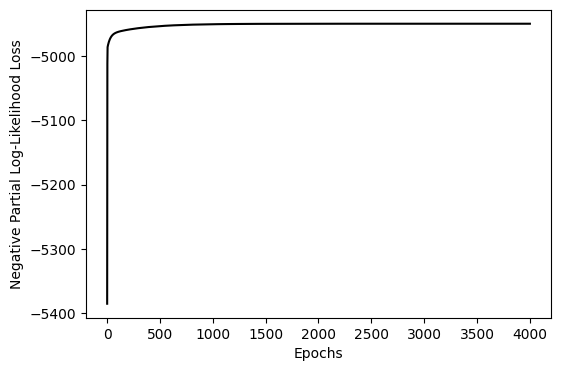

In [84]:
# Apply the VariableWeightLinear model
chf_vwl = VariableWeightLinear(chf.shape[1] - 2)

# Initial c-statistic
print("Initial VWL c-statistic:", get_concordance_statistic_nn(chf, 'StatusDeath', 'TimeDeath', chf_vwl))

# Train model
chf_vwl_loss = train_model(chf, 'StatusDeath', 'TimeDeath', chf_vwl, 0.00001, 4000, True)

Let us see the results.

In [85]:
# Final c-statistic
chf_vwl_c = get_concordance_statistic_nn(chf, 'StatusDeath', 'TimeDeath', chf_vwl)

# Print the trained weights
print("Trained VWL CHF Weights: {0} \
    \nTrained VWL CHF Loss: {1} \
    \nTrained VWL CHF c-statistic {2}"
    .format(chf_vwl.weights, chf_vwl_loss, chf_vwl_c))        

Trained VWL CHF Weights: Parameter containing:
tensor([ 0.0436, -0.1989,  0.3010,  0.5680], requires_grad=True)     
Trained VWL CHF Loss: -4949.52001953125     
Trained VWL CHF c-statistic 0.6795504455303248


Similar results. Now let's apply the same methods in applying NN models to the `Rossi` dataset upon the `CHF` dataset.

Loss before training: tensor([-5446.0146], grad_fn=<MulBackward0>)
Loss after training: tensor([-4961.4902], grad_fn=<MulBackward0>)


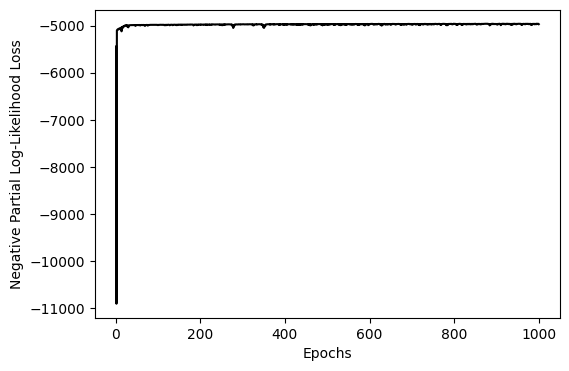

SNN[4, 16, 1] 
- Loss: [-4970.923]
- Score: 0.677987352687554


(array([-4970.923], dtype=float32), 0.677987352687554)

In [86]:
# Test the simple model on the CHF data set
chf_input_size = chf.shape[1] - 2  # Number of input features (excluding censor and time variables)
chf_hidden_size = chf_input_size*chf_input_size  # Number of hidden units
chf_output_size = 1  # Number of output units
chf_snn = SNN(chf_input_size, chf_hidden_size)
# Train model
test_nn(chf, 'StatusDeath', 'TimeDeath', chf_snn, 0.0001, 1000, True)

Let us visualize the weights of the model.

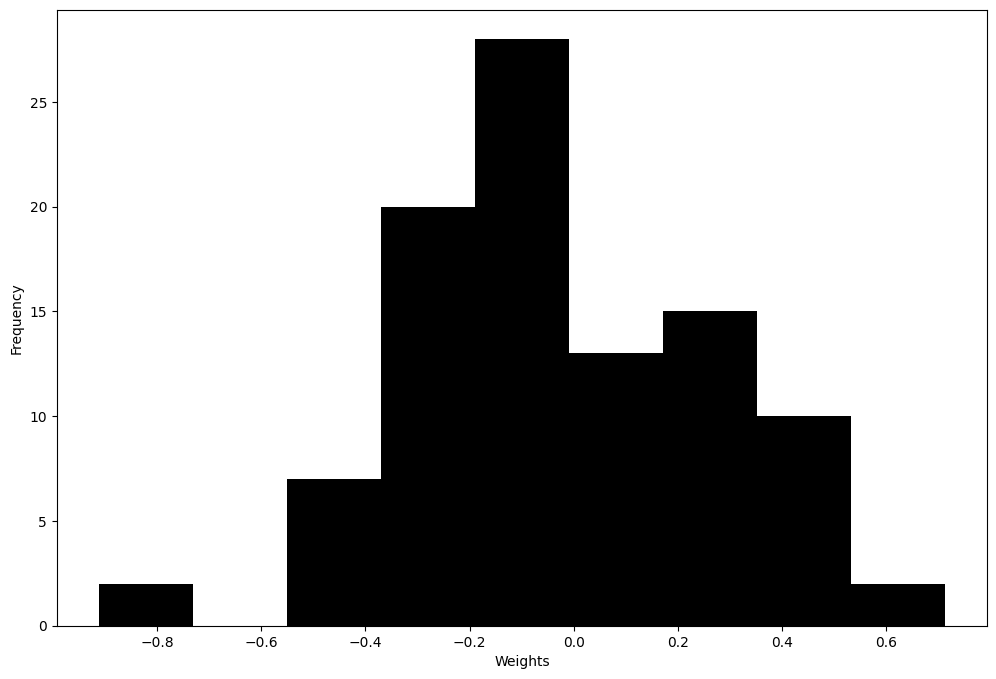

In [87]:
# Plot histogram of weights
chf_snn_weights = chf_snn.return_weights()
plt.figure(figsize=(6, 4))
plt.hist(chf_snn_weights, bins=int(np.sqrt(len(chf_snn_weights))), color='black')
plt.xlabel('Weights')
plt.ylabel('Frequency')
plt.show()

Now let us the `GNN` model, with a similar structure using the input size squared as the number of neurons in `2` hidden layer.

Loss before training: tensor([-5360.9082], grad_fn=<MulBackward0>)
Loss after training: tensor([-4948.3604], grad_fn=<MulBackward0>)


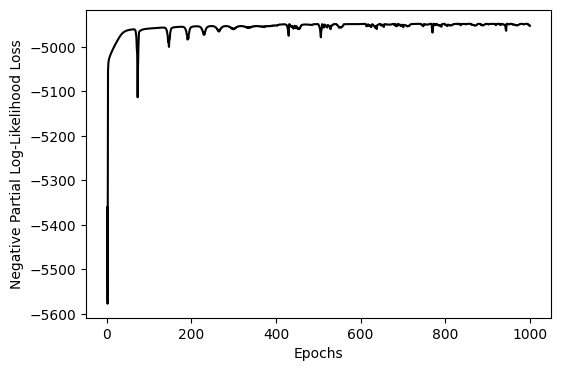

GNN[4, 16, 16, 1] 
- Loss: [-4952.9277]
- Score: 0.6795561943087094


(array([-4952.9277], dtype=float32), 0.6795561943087094)

In [88]:
# Test the GNN model on the CHF data set
chf_gnn = GNN([chf_input_size, chf_hidden_size, chf_hidden_size, 1])
test_nn(chf, 'StatusDeath', 'TimeDeath', chf_gnn, 0.0001, 1000, True)

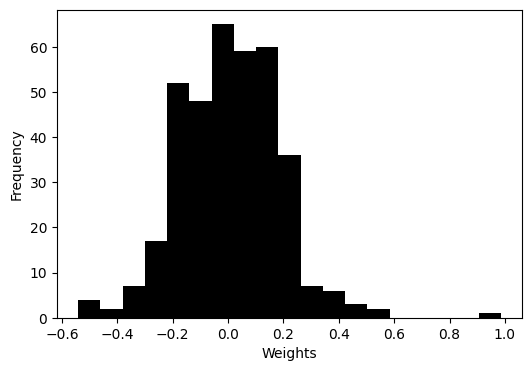

In [89]:
# Plot histogram of weights
chf_gnn_weights = chf_gnn.return_weights()
plt.figure(figsize=(6, 4))
plt.hist(chf_gnn_weights, bins=int(np.sqrt(len(chf_gnn_weights))), color='black')
plt.xlabel('Weights')
plt.ylabel('Frequency')
plt.show()

Now, it is time to use LCA. Let us first establish the baseline.

In [ ]:
chf_lca = lca(chf, 'StatusDeath', 'TimeDeath', 1)

Now we can split the data into `2` components.

In [140]:
chf_lca2 = lca(chf, 'StatusDeath', 'TimeDeath', 2)

GMM Log Likelihood: -3.901010565591099


KeyboardInterrupt: 

...with `3` classes.

In [ ]:
chf_lca3 = lca(chf, 'StatusDeath', 'TimeDeath', 3)

GMM Log Likelihood: -3.8172306205680466


KeyboardInterrupt: 

And finally using `4` classes.

In [ ]:
chf_lca4 = lca(chf, 'StatusDeath', 'TimeDeath', 4)

3    737
1    624
0    295
2    146
Name: LatentClass, dtype: int64


AttributeError: 'int' object has no attribute 'backward'

We will not use `5` values as we have not outperformed results from `Mbotwa et al. (2021)`. Likewise, we will not test on the entire dataset, however, let us prepare the data for this.

In [ ]:
data_chf_full = df
data_chf_full_imputed = data_chf_full.fillna(data_chf_full.mean())
data_chf_full_numeric = OneHotEncoder().fit_transform(data_chf_full_imputed)
print(data_chf_full_numeric.head())

chf_full = data_chf_full_numeric

We can test `lifelines` on the entire dataset.

In [ ]:
cphchf_full = CoxPHFitter().fit(chf_full, 'TimeDeath', 'StatusDeath')
cphchf_full.print_summary(columns=["coef", "se(coef)", "p"])

And plot the coefficients.

In [ ]:
# Plot the coefficients
plt.figure(figsize=(4, 3))
cphchf_full.plot()
plt.show()

`sksurv` also.

In [ ]:
# Prepare the data for the CoxPHSurvivalAnalysis
eventschf_full = [True if x > 0. else False for x in chf_full['StatusDeath']]
timeschf_full = [x for x in chf_full['TimeDeath']]
data_y_chf_full = np.array(list(zip(eventschf_full, timeschf_full)), dtype=[('Status', '?'), ('Survival_in_weeks', '<f8')])
data_x_chf_full = chf[['ClinicAge', 'Haemoglobin', 'Diabetes', 'MaleSex=Male']]

# Do the same for the CoxPHSurvivalAnalysis on CHF
estimatorchf_full = CoxPHSurvivalAnalysis()
estimatorchf_full.fit(data_x_chf_full, data_y_chf_full)
score = estimatorchf_full.score(data_x_chf_full, data_y_chf_full)
print('Estimator score is:', score)
print('Coefficients:', estimatorchf_full.coef_)

We can event compute the log likelihood with `CoxNNet`.

In [ ]:
chf_c = torch.tensor([0.04, -0.20, 0.30, 0.57], requires_grad=True)
chf_net_c = CoxNNet(chf, 'StatusDeath', 'TimeDeath', coefficients=chf_c)
chf_net_c.forward()

## Visualising the data

We can also visualise the data.

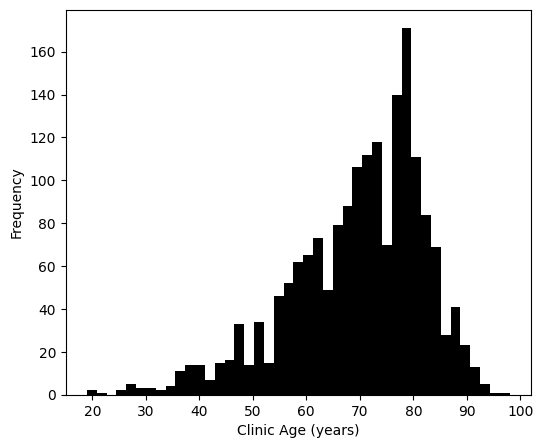

In [ ]:
# Calculates number of bins for the histograms by taking the square root of the number of data points (comes out as 50)
n_bins = int(np.ceil(np.sqrt(data_x_numeric4oh.shape[0])))

# Plot histogram for ClinicAge
# Set figure size
plt.figure(figsize=(6, 5))
plt.hist(data_x_numeric4oh['ClinicAge'], bins=n_bins, color="black")
plt.xlabel('Clinic Age (years)')
plt.ylabel('Frequency')
plt.savefig('ClinicAgeDistribution.png')
plt.show()

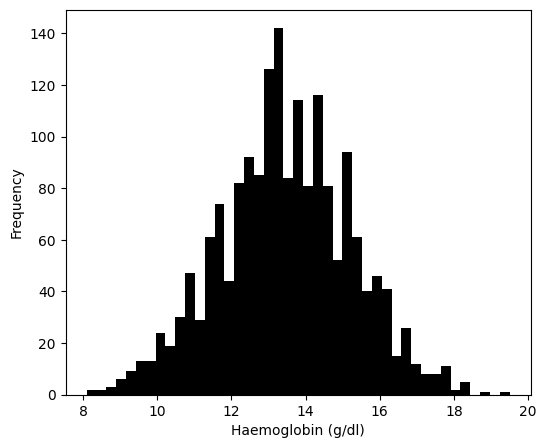

In [ ]:
# Plot histogram for ClinicAge
plt.figure(figsize=(6, 5))
plt.hist(data_x_numeric4oh['Haemoglobin'], bins=n_bins, color="black")
plt.xlabel('Haemoglobin (g/dl)')
plt.ylabel('Frequency')
plt.savefig('HaemoglobinDistribution.png')
plt.show()

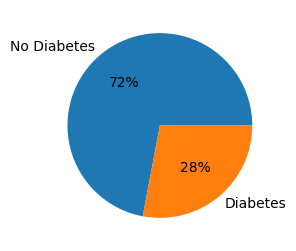

In [ ]:
# Create pie chart for each categorical feature of interest
diabetes = data_x_numeric4oh['Diabetes'].copy()
# Replace 0 with 'No Diabetes' and 1 with 'Diabetes'
diabetes.replace({0: 'No Diabetes', 1: 'Diabetes'}, inplace=True)
diabetes.value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(3, 3))
plt.ylabel('')
plt.show()

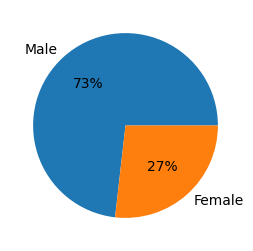

In [ ]:
# Create pie chart for each categorical feature of interest
sex = data_x_numeric4oh['MaleSex=Male'].copy()
# Replace 0 with 'Female' and 1 with 'Male'
sex.replace({0: 'Female', 1: 'Male'}, inplace=True)
sex.value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(3, 3))
plt.ylabel('')
plt.show()

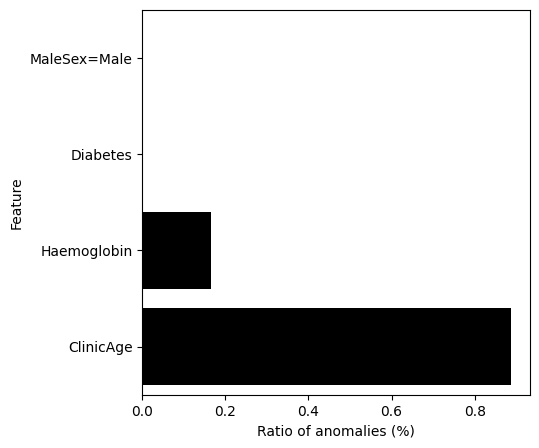

In [ ]:
# Calculate standard deviation of each feature
std = data_x_numeric4oh.std()
outlier_upper_threshold = data_x_numeric4oh.mean() + 3*std
outlier_lower_threshold = data_x_numeric4oh.mean() - 3*std
# Calculate and plot the ratio of number of outliers to number of data in each feature
outlier_ratio = ((data_x_numeric4oh > outlier_upper_threshold).sum() + (data_x_numeric4oh < outlier_lower_threshold).sum())/data_x_numeric4oh.shape[0] * 100
# Sort x axis by outlier ratio
outlier_ratio.sort_values(ascending=False, inplace=True)
outlier_ratio.plot(kind='barh', figsize=(5, 5))
# Horizontal black bars
plt.barh(outlier_ratio.index, outlier_ratio, color='black')
plt.xlabel('Ratio of anomalies (%)')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Compute direct correlations of selected features with the target variable
correlations_original = data_x_numeric4oh.corrwith(target)
# Sort them according the strength of correlations.
correlations_index = correlations_original.abs().sort_values(kind="quicksort", ascending=False).index
# Use index to sort correlations
correlations = correlations_original[correlations_index]
# Display correlation value from original dataframe
correlations_df = pd.DataFrame(correlations, index=correlations.index, columns=['Correlation'])
# Print correlations
display(correlations_df)

,Correlation
ClinicAge,0.256941
Haemoglobin,-0.202872
MaleSex=Male,0.095669
Diabetes,0.090201


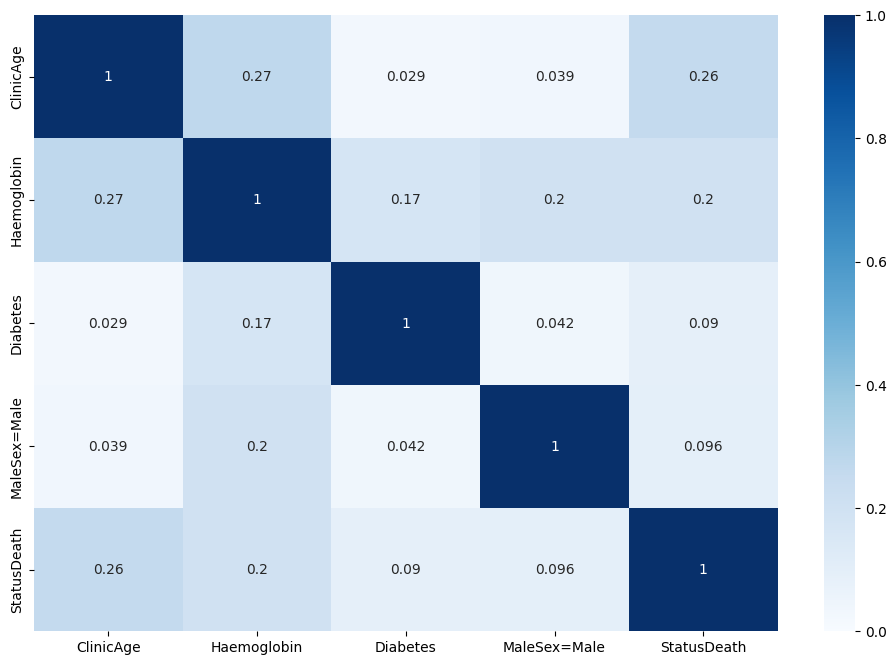

In [ ]:
import seaborn as sns

# Combine target variable to the dataframe (new dataframe)
correlations_df_with_target = pd.concat([data_x_numeric4oh, target], axis=1)

# Create heatmap of all correlations
correlation=correlations_df_with_target.corr().abs()
heatmap = sns.heatmap(correlation, vmin=0, vmax=1, annot=True, cmap='Blues')
plt.show()

## External Packages

In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn",
            "sksurv": "scikit-survival"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

matplotlib==3.6.2
torch==2.0.0+cu118
numpy==1.23.5
pandas==1.5.2
lifelines==0.27.4
scikit-survival==0.20.0
seaborn==0.12.1
